# Goal
To make a translator that is able to detect the text from an image, identify its language, convert it to English and convert to audio output.

# 1. Optical Character Recognition

Main
- https://nanonets.com/blog/ocr-with-tesseract/
- https://pyimagesearch.com/2021/09/20/language-translation-and-ocr-with-tesseract-and-python/

Others
- https://builtin.com/data-science/python-ocr
- https://towardsdatascience.com/extract-text-written-in-different-languages-from-images-with-python-2348ff021fe5
- https://towardsdatascience.com/4-python-libraries-to-detect-english-and-non-english-language-c82ad3efd430
- https://www.analyticsvidhya.com/blog/2021/06/optical-character-recognitionocr-with-tesseract-opencv-and-python/
- https://medium.com/analytics-vidhya/scene-text-detection-recognition-and-translation-ad20c31e869e

## Install Library

In [2]:
# !pip install pytesseract
# !pip install opencv-python

## Import Libraries
- https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i

In [157]:
import pytesseract
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Set Configuration Settings
- The --oem argument, or OCR Engine Mode, controls the type of algorithm used by Tesseract. 
- The --psm controls the automatic Page Segmentation Mode used by Tesseract.

In [4]:
# Adding custom options
custom_config = r'--oem 3 --psm 6'

## Preprocessing for Tesseract
- To avoid all the ways your tesseract output accuracy can drop, we need to ensure that image is pre-processed
- E.g Rescaling, Binarisation, Noise Removal, Deskewing etc

**Get Grayscale**
- https://www.geeksforgeeks.org/python-opencv-cv2-cvtcolor-method/

In [5]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

### Import Image

In [6]:
## Import Image and Test
image = cv2.imread('aurebesh.jpg')

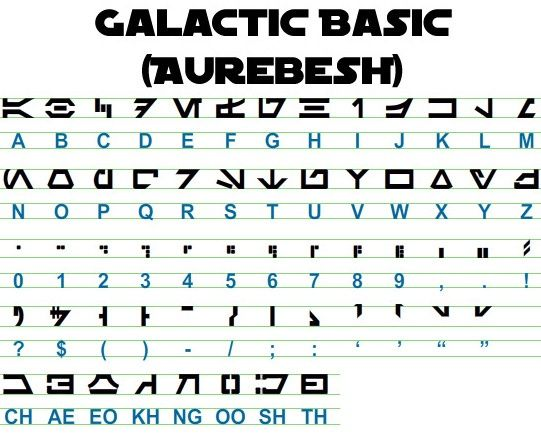

In [7]:
#Display Image
from IPython.display import Image
Image(filename='aurebesh.jpg') 

## Apply Pre-processing to Image
- https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

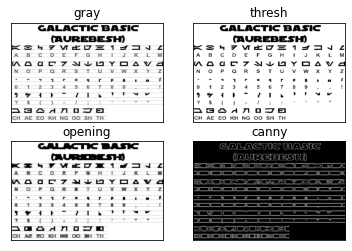

In [8]:
gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)

titles = ["gray", "thresh", "opening", "canny"]
images = [gray, thresh, opening, canny]

for i in range(len(images)):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255, aspect='auto')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

plt.show()

### Test Image output after image Pre-Processing

In [9]:
#Set Tesseract path in script to avoid error
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#### Original Image

In [10]:
print(pytesseract.image_to_string(image, config=custom_config))

GALACTIC BASIC
(AUREBESH)
RE TFVMVEVE ITZ IoIN.L
AB CUD ET FE GG mn Td KC
AOder7NvToYoAVaA
N_ Oo. 8 _ HG RS Ty wee Ve
a a F< 2
Sy a a a ay Se ae: |
i a a ey ee ee
2 a (a a eS
ASGaSANADI
CH AE EO KH NG OO SH TH



#### Grayscale Image

In [11]:
print(pytesseract.image_to_string(gray, config=custom_config))

GALACTIC BASIC
(AUREBESH)
Reh FVMVEVESITZwIoIN.L
A 2 > EE eS er ek oe
AOder7NvToYoAVA
NOP ED Re SS TT nv ween
a a |
ey a ar eS . ay Se a: ee |
i a oe eee ee ee
7S ys Ee ee
ASaSANnNADIe
CH AE EO KH NG OO SH TH



#### Threshold Image

In [12]:
### Thresholding
print(pytesseract.image_to_string(thresh, config=custom_config))

GALACTIC BASIC
(AVREBESH)

RE 7FVMeEVEiefv ol Z
A B C DE F GH IJ K LM
AOdCerT7NVToOYOAVA
N O P Q@R $$ TU VW XK Y¥Y Z
"oe 3 3 rm 8 fo Pf F Bo a om %
0 12 3 4 5 6 7 89 , . !
a A
2 S$ ( Foe Fo gor ot toe
AadSANADIeE
CH AE EO KH NG OO SH TH



#### Opening Image

In [13]:
### Opening
print(pytesseract.image_to_string(opening, config=custom_config))

GALACTIC BASIC
(AUREZEBELSH)
KEE VTMEUE iwoayvs
A BC D HE F @ H [| J K TL
AOadr7Wt HYOAVaA
WO P Q R 8S T U VW WK y Z
a J
S12 ya ib 8 7 Sb Ps,
7Vir- -yrp»ptTttYY
~ Et ys i eg Ee ee
AGMGoOAnNnoOoIH
CH AE BO KH @@ OO BH TH



## Getting Boxes around text
- Get Bounding Box information for OCR Results

In [14]:
### Import New Image
image2 = cv2.imread('invoice-sample.jpg')

### Boxes around character

In [15]:
# h, w, c = image.shape
# boxes = pytesseract.image_to_boxes(image) 
# for b in boxes.splitlines():
#     b = b.split(' ')
#     img = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

# cv2.imshow('img', image)
# cv2.waitKey(0)

### Boxes around words

#### Convert Image information to key components in dictionary format.

In [16]:
from pytesseract import Output

d = pytesseract.image_to_data(image2, output_type=Output.DICT)
print(d.keys())

dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


In [17]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image2 = cv2.rectangle(image2, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('image2', image2)
cv2.waitKey(0)

-1

### Display Result
- https://www.folkstalk.com/2022/10/display-cv2-image-in-jupyter-notebook-with-code-examples.html
- https://www.folkstalk.com/2022/10/matplotlib-pyplot-imshow-size-with-code-examples.html

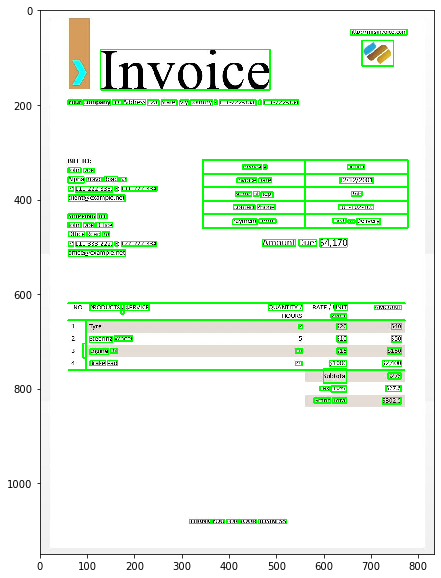

In [18]:
plt.figure(figsize = (20,10))
plt.imshow(image2, interpolation='nearest')

# 2. Testing Translator on Chinese and Japanese

- Download the trained data for required languages from this link
(https://github.com/tesseract-ocr/tessdata/)
- https://ocrmypdf.readthedocs.io/en/latest/languages.html

Consider
- https://github.com/Mimino666/langdetect/issues/51
- https://polyglot.readthedocs.io/en/latest/Detection.html
- https://polyglot.readthedocs.io/en/latest/Installation.html

### Configuring Tesseract for Chinese(Simplified), Chinese(Traditional) and Japanese

In [19]:
# Adding custom options
custom_config = r'-l chi_sim+chi_tra+jpn --oem 3 --psm 6'

### Installing Required Libary for translator/Text-To-Speech

**Translator**
<br>
Main
- https://towardsdatascience.com/language-translation-using-python-bd8020772ccc (For Translation)
- https://towardsdatascience.com/4-nlp-libraries-for-automatic-language-identification-of-text-data-in-python-cbc6bf664774 (For Language Detection)
- https://cloud.google.com/translate/docs/languages

Others
- https://www.thepythoncode.com/article/translate-text-in-python

**Text-To-Speech**
Main
- https://www.geeksforgeeks.org/convert-text-speech-python/

In [156]:
#Correct
#Translator
# !pip install translators --upgrade
# !pip install langdetect

#Text to Speech
# !pip install gTTS

#Deprecated
# !pip install googletrans==4.0.0-rc1
# !pip install -U textblob

### Import required library

In [142]:
#Translation
import translators as ts
from langdetect import detect, detect_langs

#Text To Speech
from gtts import gTTS
import os

# from googletrans import Translator
#Deprecated
# from textblob import TextBlob

### Chinese (Simplified)

#### Import New Image

In [111]:
image3 = cv2.imread('chinese-sample.jpg')

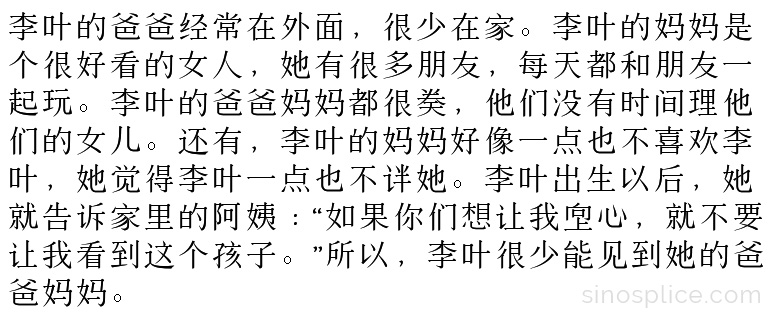

In [112]:
Image(filename='chinese-sample.jpg') 

#### Run Character Recognition

In [113]:
text3 = pytesseract.image_to_string(image3, config=custom_config)
print(pytesseract.image_to_string(image3, config=custom_config))

李 叶 的 爸 爸 经 常 在 外 面 , 很 少 在 家 。 李 叶 的 妈 妈 是
不 禎 好 看 的 女 人 , 姓 有 禎 多 朋 友 , 毎 天 都 和 朋 又 一
起 玩 。 李 叶 的 爸 爸 妈 妈 都 很 粪 , 他 们 没 有 时 间 理 他
们 的 女 儿 。 还 有 , 李 叶 的 妈 妈 好 像 一 点 也 不 喜 欢 李
叶 , 她 觉 得 李 叶 一 点 也 不 详 她 。 李 叶 出 生 以 后 , 她
就 告 诉 家 里 的 阿 姨 : “ 如 果 你 们 想 让 我 白 心 , 就 不 要
巡 我 看 到 迕 代 孩 子 。 ” 所 以 ， 幸 吐 很 少 能 見 到 她 的 菌
爸 妈 妈 。



In [140]:
#Detect Language in ISO693 format corresponding to language identified
result3 = detect(text3)
result3 = "zh-CN"
#Translate string identified to english
convText3 = ts.google(text3, from_language=result3, to_language='en')
print(ts.google(text3, from_language=result3, to_language='en'))

# translation = translator.translate("Test", dest='en')

# tb = TextBlob(text3)
# tb.detect_language()
# print(tb.translate(from_lang=tb.detect_language(), to="en"))

Li Ye's dad is often at home and rarely at home. Li Ye's mother is 
 Women who are not good -looking, surnames have a lot of friends, and the sky is another with friends 
 Play. Li Ye’s father and mother are very dung, they have no time to ignore him 
 Girls. Also, Li Ye’s mother looks like a little bit and does not like Li Li 
 Ye, she felt that Li Ye was unknown at all. After Li Ye was born, she 
 Just tell the aunt at home: "If you want me to make me white, don’t 
 I saw the child on behalf of the child. "Therefore, Xing Tu rarely see her bacteria 
 Mom and mother.


In [140]:
#Detect Language in ISO693 format corresponding to language identified
result3 = detect(text3)
result3 = "zh-CN"
#Translate string identified to english
convText3 = ts.google(text3, from_language=result3, to_language='en')
print(ts.google(text3, from_language=result3, to_language='en'))

# translation = translator.translate("Test", dest='en')

# tb = TextBlob(text3)
# tb.detect_language()
# print(tb.translate(from_lang=tb.detect_language(), to="en"))

Li Ye's dad is often at home and rarely at home. Li Ye's mother is 
 Women who are not good -looking, surnames have a lot of friends, and the sky is another with friends 
 Play. Li Ye’s father and mother are very dung, they have no time to ignore him 
 Girls. Also, Li Ye’s mother looks like a little bit and does not like Li Li 
 Ye, she felt that Li Ye was unknown at all. After Li Ye was born, she 
 Just tell the aunt at home: "If you want me to make me white, don’t 
 I saw the child on behalf of the child. "Therefore, Xing Tu rarely see her bacteria 
 Mom and mother.


In [149]:
speech3 = gTTS(text=convText3, lang="en", slow=False)
speech3.save("Chinese(Simplified).mp3")

### Chinese (Traditional)

#### Import New Image

In [74]:
image4 = cv2.imread('chinese-trad-sample.jpg')

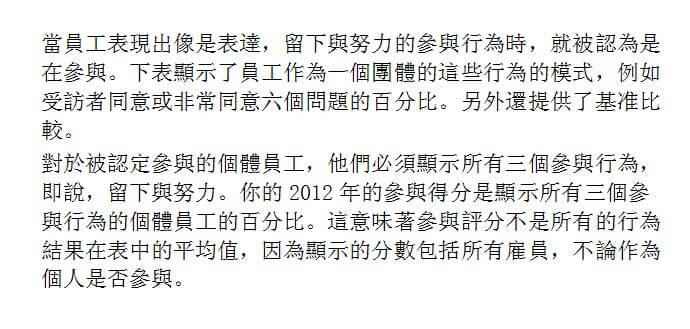

In [75]:
Image(filename='chinese-trad-sample.jpg') 

#### Run Character Recognition

In [76]:
text4 = pytesseract.image_to_string(image4, config=custom_config)
print(pytesseract.image_to_string(image4, config=custom_config))

當 員 工 表 現 出 像 是 表 達 ， 留 下 與 努 力 的 參 與 行 為 時 ， 就 被 認 為 是
在 參 與 。 下 表 顯 示 了 員 工 作 為 一 個 團 體 的 這 些 行 為 的 模 式 ， 例 如
受 訪 者 同 意 戚 非 常 同 意 六 個 問 題 的 百 分 比 。 另 外 還 提 供 了 基 准 比
較 。

對 於 被 認 定 參 與 的 個 體 員 工 ， 他 們 必 須 顯 示 所 有 三 個 參 與 行 為 ，
即 设 , 留 下 与 努 力 。 你 的 2012 年 的 參 與 得 分 是 顯 示 所 有 三 個 參
與 行 為 的 個 體 員 工 的 百 分 比 。 這 意 味 著 參 與 評 分 不 是 所 有 的 行 為
结 果 在 表 中 的 平 均 值 , 囡 为 春 示 的 分 数 包 括 所 有 雇 员 , 不 论 作 为
个 人 是 否 参 与 。



In [152]:
#Detect Language in ISO693 format corresponding to language identified
result4 = detect(text4)
result4 = 'zh-TW'
#Translate string identified to english
convText4 = ts.google(text4, from_language=result4, to_language='en')
print(ts.google(text4, from_language=result4, to_language='en'))

When the employee watch is like a table, and when you leave the tribute with Nu Li, it is considered to be 
 Participate in. The following table shows that the employees are used as a group of patterns as a group. For example, 
 The interviewees are all the same as Qi Fei. In addition, it also provides a base ratio 
 Compare. 

 For the staff who have been determined to participate, they must show all the three participating behaviors, 
 Set, leave and Nu Li. Your 2012 ginseng score is showing all three ginseng 
 Hundreds of cents with a sample employee. This means that participating scores are not all the lines 
 The average value of the result in the table, the scores shown in spring include all employees, regardless of 
 Do you participate?


In [153]:
speech4 = gTTS(text=convText4, lang="en", slow=False)
speech4.save("Chinese(Traditional).mp3")

### Japanese

#### Import New Image

In [82]:
image5 = cv2.imread('jap-sample.png')

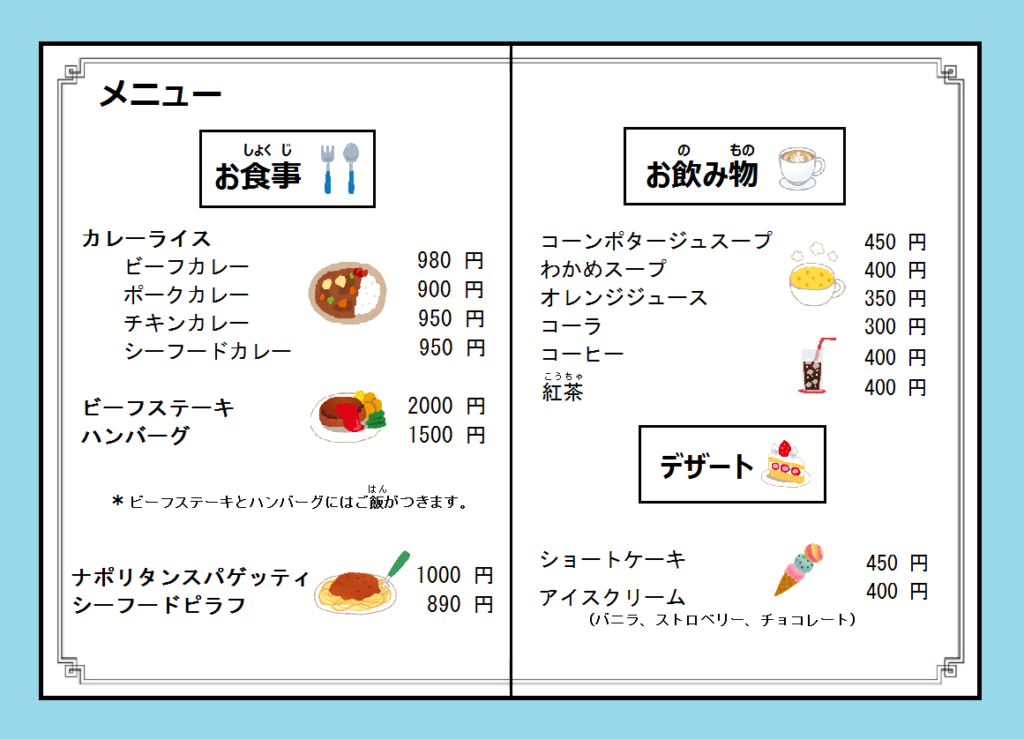

In [83]:
Image(filename='jap-sample.png') 

#### Run Character Recognition

In [84]:
text5 = pytesseract.image_to_string(image5, config=custom_config)
print(pytesseract.image_to_string(image5, config=custom_config))

嗎
メ ニ ュ ー
e く も o 。 *o _ ふ
お 食 事 | 1 お 飲 み 物
カ レ ー ラ イ ス コ ー ン ポ タ ー ジ ュ ス ー プ 450 日
巳 一 力 一 ⑨⑧0 円 | ゎ か め ス ー プ 居 春 , 400 円
ポ ー ク カ レ ー .˙ 900 円 | オ レ ン ジ ジ ュ ー ス ③⑤0 日
チ キ ン カ レ ー ⑨⑤0 円 | コ ー ラ 300 日
シ ー フ ー ド カ レ ー ⑨⑤0 円 | コ ー ヒ ー 旦广 400 日
R
向 荒 400 日
ビ ー フ ス テ ー キ ˍ 2000 円 | 刊 萊
ハ ン バ ー ゲ グ ⑮00 円 5
キ ビ」フステ」キとハンバ」グにはこ響ヵ『つきます~
ノ シ ョ ー ト ケ ー キ 缙 ④⑤0 円
ナ ポ リ タ ン ス パ ゲ ッ テ ィ 1000 弓 ラ イ ス ク リ ー ム ダ “ 400 田
シ ー フ ー ド ビ ピ ラ フ ペ ー ー 890 白 ( が ニ ラ 、 ス ト ロ ベ リ ー チ ョ コ レ ー
曰



In [154]:
#Detect Language in ISO693 format corresponding to language identified
result5 = detect(text5)
#Translate string identified to english
convText5 = ts.google(text5, from_language=result5, to_language='en')
print(ts.google(text5, from_language=result5, to_language='en'))

Lingering 
 menu 
 E Kumo O. *o _f 
 Food | 1 Drinking 
 Karai Raiscon Potaji 450 days 
 Simi Ichiki Ichiki ⑨0 yen | ゎ Kame Supai Spring, 400 yen 
 Pokkaray. 900 yen | Olinji -suz ③ 4 0 0 days 
 Chikinkare ⑨ 円0 yen | Colla 300 days 
 Sea Fudokare ⑨ 円0 yen 
 R 
 400 days of direction 
 Beautifications ˍ 2000 yen | Published 萊 
 Hanba Geu Ge Ge Ge Ge Ge Ga 
 Kibi "Future" Ki and Hamba " 
 No Shotoki 缙 ④ 4 yen 
 Naponton Spa Getti 1000 Bow Laisle Mid "400 Tadashi 
 Seafood Bed Pirapira 890 White (Nira, Strober Chocolate 
 Say


In [155]:
speech5 = gTTS(text=convText5, lang="en", slow=False)
speech5.save("Japanese.mp3")

## Instant Translator
- https://www.youtube.com/watch?v=1QwT2_-WEBQ

### Installing required Libraries for translation

In [88]:
#!pip install deep-translator
# !pip install detectlanguage

### Importing required libraries for translation
API Key
- https://detectlanguage.com/documentation

In [89]:
import deep_translator.exceptions
from deep_translator import GoogleTranslator, single_detection
import detectlanguage
detectlanguage.configuration.api_key = "5b9a2ceaac1e77dfd3be4c8fb03fce8b"

### Import simple image

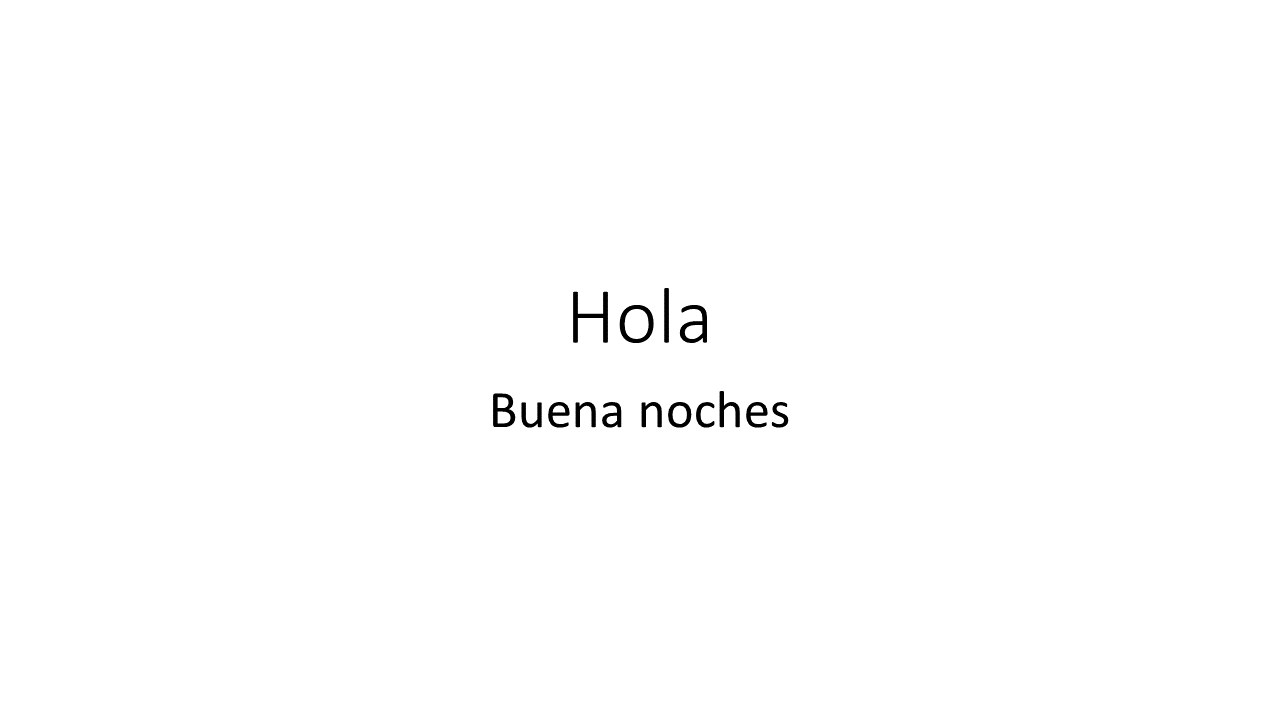

In [99]:
image5 = cv2.imread('Hola.png')
Image(filename='Hola.png') 

## Translate with picture result

In [100]:
boxes = pytesseract.image_to_data(image5)
hImg, wImg, _ = image5.shape

for x, b in enumerate(boxes.splitlines()):
    if x != 0:
        b = b.split()
        if len(b) == 12:
            x, y, w, h = int(b[6]), int(b[7]), int(b[8]), int(b[9])
            cv2.rectangle(image5, (x,y), (w + x, h + y), (0, 0, 255), 1)
            text = b[11]
            try:
                lang = single_detection(text, api_key="5b9a2ceaac1e77dfd3be4c8fb03fce8b")
                try:
                    translated_text = GoogleTranslator(source=lang, target='english').translate(text)
                    cv2.putText(image5, translated_text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 2)
                except deep_translator.exceptions.InvalidSourceOrTargetLanguage:
                    cv2.putText(image5, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
            except IndexError:
                cv2.putText(image5, text, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (50, 50, 255), 1)
            
        

cv2.imshow('Result', image5)
cv2.waitKey(0)

-1

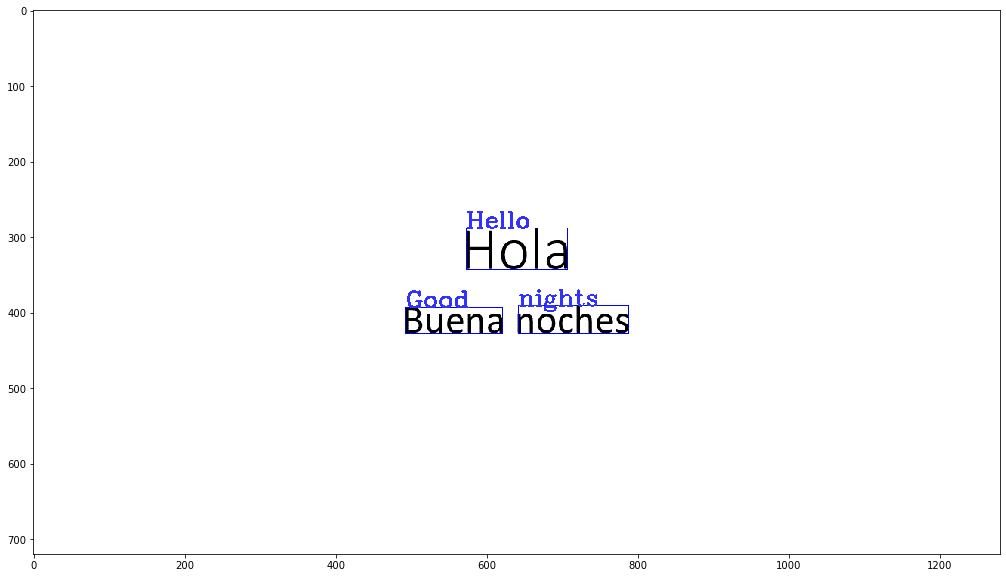

In [102]:
plt.figure(figsize = (20,10))
plt.imshow(image5, interpolation='nearest')